df_tr columns: ['ts', 'charger_id', 'occupied', 'session_id', 'vehicle_name', 'vehicle_class', 'soc', 'power_kw']

Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 1
Erster Timestamp:  2025-12-01 00:00:00
Letzter Timestamp: 2025-12-01 23:55:00
Simulationshorizont: 1 Tage

Kalenderische Tage je Tagtyp:
- working_day: 1 Tage
- saturday: 0 Tage
- sunday_holiday: 0 Tage

📊 Sessions im Simulationshorizont
BEV-Ankünfte mit Ladebedarf: 3
BEV-Fahrzeuge mit Ladezugang: 2
BEV ohne Ladezugang (drive_off): 1
Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.


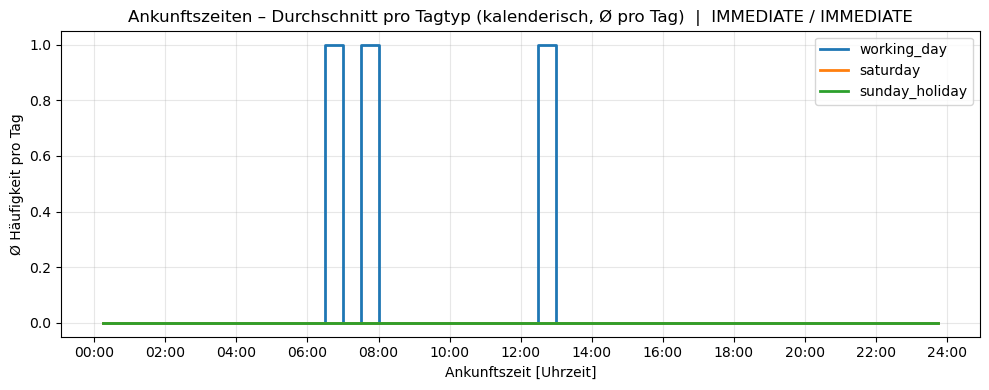

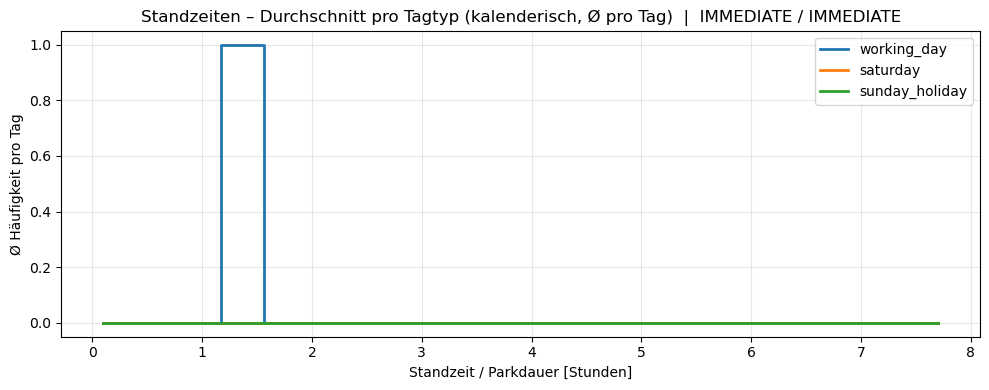

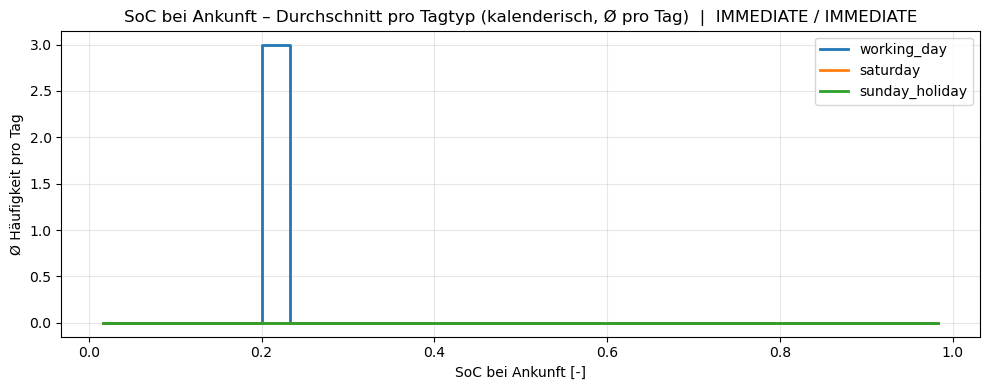

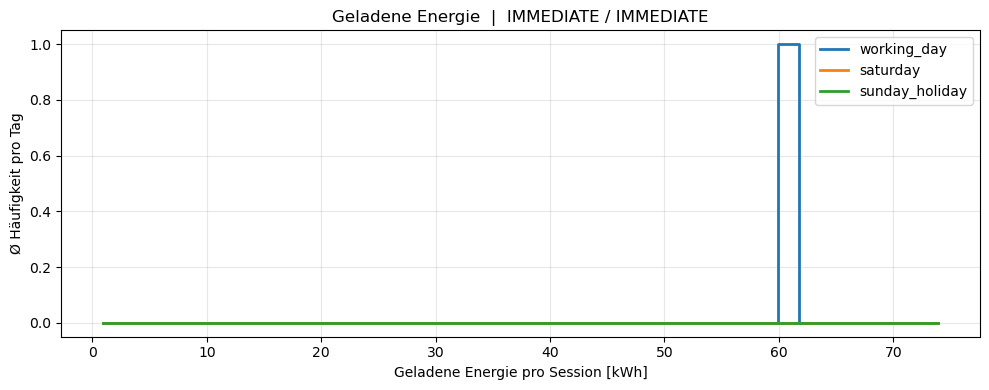

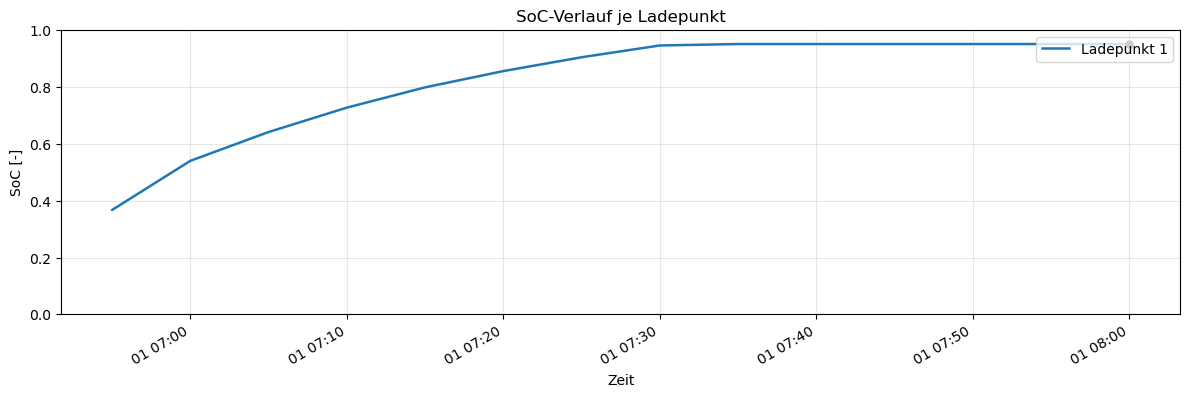

[0.2, 0.2, 0.2]
[0.95, 0.95, 0.95]


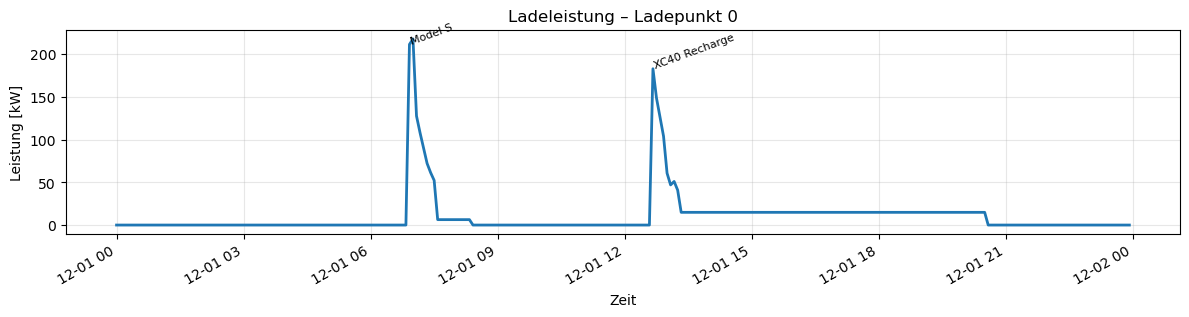

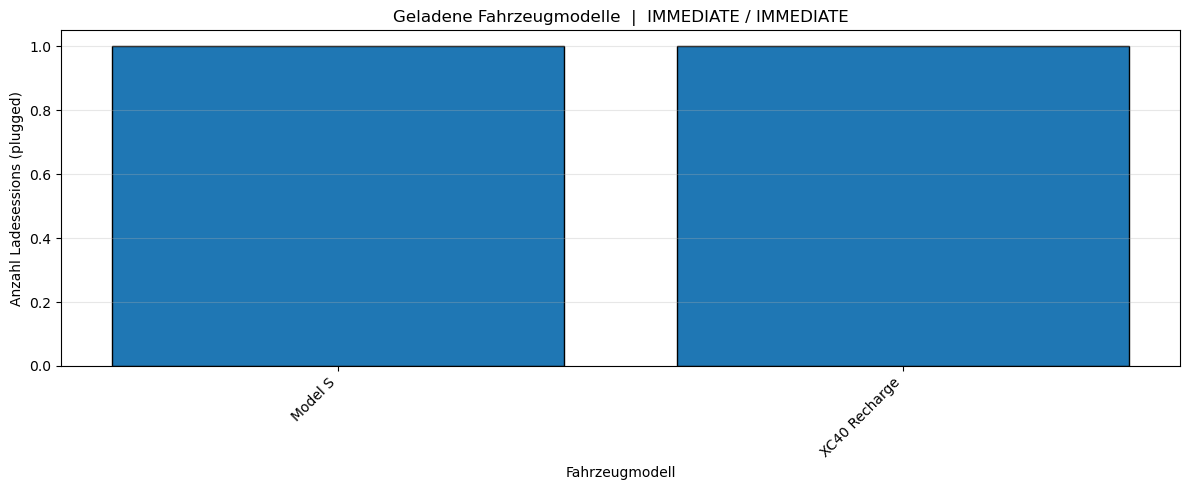

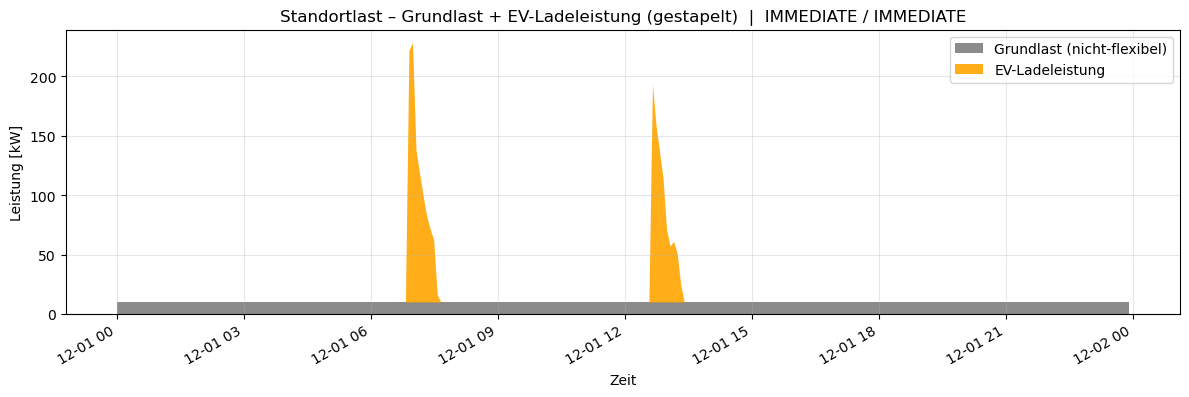

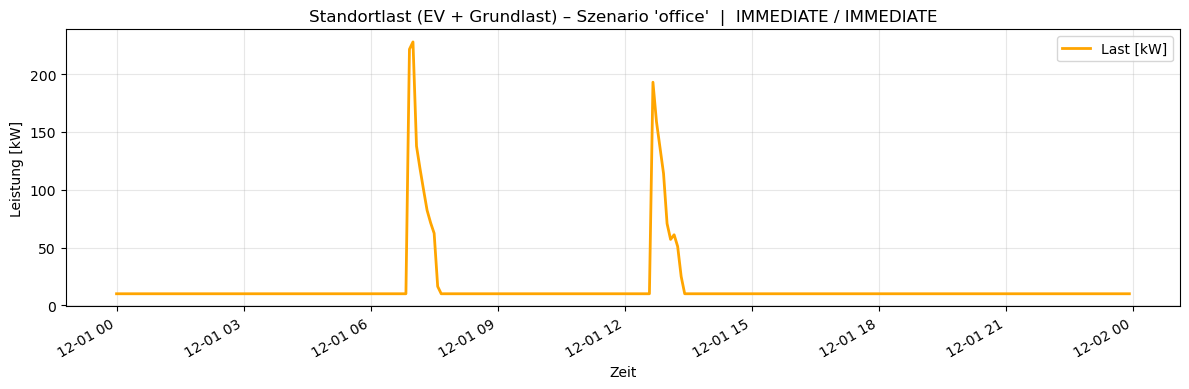

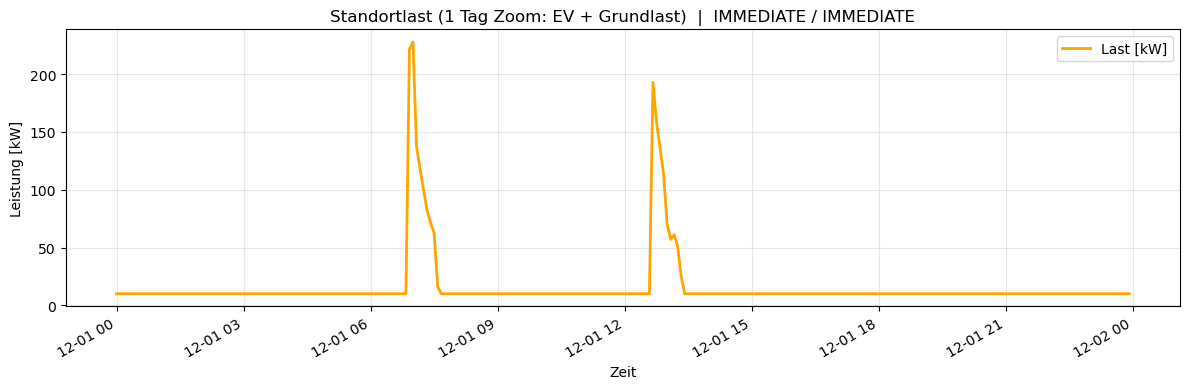

,vehicle_name,date,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,Model S,2025-12-01,06:53,08:22,1.47,75.0,0.0,0
1,XC40 Recharge,2025-12-01,12:36,20:32,7.93,61.5,0.0,0



🧩 Nutzung der Lademodi – Sessions
Sessions mit Ladevorgang insgesamt: 2
Sessions mit PV-Ladung:             0
Sessions mit Marktladen:            0
Sessions mit Sofortladen:           2
Sessions mit mehreren Modi:         0

⚡ Geladene Energie nach Lademodus [kWh]
Generation:   0.00
Market:       0.00
Immediate:    136.50


In [11]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from datetime import timedelta
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# =============================================================================
# Modulüberblick
# =============================================================================
# Dieses Notebook führt eine Simulation aus und erzeugt Auswertungen/Plots aus der Datei "simulation.py"


# =============================================================================
# 0) Plot-Farben (global konsistent)
# =============================================================================
COLOR_GENERATION = "green"    # Erzeugung / PV / Strategy (generation)
COLOR_LOAD = "orange"         # Last / EV / Standortlast
COLOR_BASELOAD = "#7f7f7f"    # Grundlast (neutral grau)


# =============================================================================
# 1) Notebook-UI Helpers
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    """
    Diese Funktion zeigt im Notebook eine farbige Statusbox für Strategie und Status an.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    """
    Diese Funktion ergänzt Plot-Titel um Strategie- und Statusinformationen.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 2) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


# =============================================================================
# 2b) Imports aus dem neuen Simulationsmodul
# =============================================================================
# Diese Zelle importiert die Simulation und alle Notebook-Helfer.
# Falls einzelne Helper in der Datei noch nicht existieren (z.B. build_strategy_signal_series),
# wird sauber auf None zurückgefallen, damit das Notebook trotzdem läuft.
from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
    build_pv_unused_table,
)

# Neu: KPI Helper / Reporting (Notebook) – muss in deiner simulation.py ergänzt sein
try:
    from model.simulation import summarize_sessions_by_charging_mode, summarize_energy_by_charging_mode
except Exception:
    summarize_sessions_by_charging_mode = None
    summarize_energy_by_charging_mode = None

# build_strategy_signal_series ist optional (kann in deiner neuen simulation.py fehlen)
try:
    from model.simulation import build_strategy_signal_series  # optional
except Exception:
    build_strategy_signal_series = None


# =============================================================================
# 3) Szenario laden und Simulation durchführen
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)

try:
    (
        timestamps,
        load_kw,
        sessions,
        charging_counts,
        holiday_dates,
        charging_strategy,
        strategy_status,
        debug_rows,
        charger_traces,
    ) = simulate_load_profile(
        scenario,
        record_debug=True,
        record_charger_traces=True,
    )

except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    raise

show_strategy_status_html(charging_strategy, strategy_status)

# Charger-Traces als DataFrame (robust)
df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])
print("df_tr columns:", df_tr.columns.tolist())
if len(df_tr) > 0:
    df_tr["ts"] = pd.to_datetime(df_tr["ts"])

# =============================================================================
# 4) Strategie-Signalreihen (optional) – Generation + Market separat
# =============================================================================
generation_series = None
generation_ylabel = None

market_series = None
market_ylabel = None

if build_strategy_signal_series is not None:
    # Diese Logik erzeugt Strategie-Signalplots, falls die Funktion im Modul existiert.
    if charging_strategy.lower() == "generation":
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="generation",
            normalize_to_internal=True,  # -> kW
            strategy_resolution_min=15,
        )
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,  # -> €/kWh
            strategy_resolution_min=15,
        )

    elif charging_strategy.lower() == "market":
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,  # -> €/kWh
            strategy_resolution_min=15,
        )


# =============================================================================
# 5) Kurze Simulation-Infos + KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
print(f"Erster Timestamp:  {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 6) Daytype + Gruppierungen
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)

print("\nKalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Infos zu den BEV-Ladevorgängen
# =============================================================================
summary = summarize_sessions(sessions)
print("\n📊 Sessions im Simulationshorizont")
print("BEV-Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("BEV-Fahrzeuge mit Ladezugang:", summary["num_sessions_plugged"])
print("BEV ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print(f"Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: {len(df_not_reached)}")
    display(df_not_reached)


# =============================================================================
# 8) Histogramm-Helper
# =============================================================================
def minutes_since_midnight(dt: datetime) -> float:
    """
    Diese Funktion berechnet Minuten seit Mitternacht für einen Zeitpunkt.
    """
    return dt.hour * 60 + dt.minute + dt.second / 60.0


def feat_arrival_hours(s) -> float:
    """
    Diese Funktion extrahiert die Ankunftszeit als Stunde des Tages.
    """
    return minutes_since_midnight(s["arrival_time"]) / 60.0


def feat_parking_hours(s) -> float:
    """
    Diese Funktion extrahiert die Standzeit als Stunden.
    """
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0


def feat_soc_arrival(s) -> float:
    """
    Diese Funktion extrahiert den SoC bei Ankunft.
    """
    return float(s["soc_arrival"])


def feat_delivered_kwh(s) -> float:
    """
    Diese Funktion extrahiert die geladene Energie (kWh) einer Session.
    """
    return float(s.get("delivered_energy_kwh", 0.0))


def average_hist_per_daytype_calendar(
    daytype_to_days: dict,
    sessions_by_day: dict,
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    """
    Diese Funktion berechnet Durchschnitts-Histogramme pro Tagtyp (kalenderisch).
    """
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(
    avg_counts_by_type,
    bin_edges,
    xlabel,
    base_title,
    charging_strategy,
    strategy_status,
    xticks=None,
    xtick_labels=None,
):
    """
    Diese Funktion plottet überlagerte Durchschnitts-Histogramme für working_day/saturday/sunday_holiday.
    """
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 9) Histogramme
# =============================================================================
if timestamps is not None and sessions is not None and days_by_type_calendar:
    # Ankunftszeiten
    arrival_bin_edges = np.linspace(0, 24, 49)
    avg_arrival = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_arrival_hours, arrival_bin_edges)
    plot_avg_hist_overlay(
        avg_arrival, arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )

    # Standzeiten
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = max(np.percentile(all_parking, 99) if len(all_parking) else 1.0, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)
    avg_parking = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_parking_hours, parking_bin_edges)
    plot_avg_hist_overlay(
        avg_parking, parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    # SoC bei Ankunft
    soc_bin_edges = np.linspace(0, 1, 31)
    avg_soc = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_soc_arrival, soc_bin_edges)
    plot_avg_hist_overlay(
        avg_soc, soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    # Geladene Energie (plugged-only)
    plugged_list = [s for s in sessions if s.get("_plug_in_time") is not None]
    all_energy = np.array([feat_delivered_kwh(s) for s in plugged_list], dtype=float)
    max_e = max(np.percentile(all_energy, 99) if len(all_energy) else 1.0, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)
    avg_energy = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day_plugged, feat_delivered_kwh, energy_bin_edges)
    plot_avg_hist_overlay(
        avg_energy, energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

# =============================================================================
# 10) Ladekurven ausgewählter Fahrzeuge
# =============================================================================

def plot_soc_by_chargers(df_tr, charger_ids=None, start=None, end=None):
    if df_tr is None or len(df_tr) == 0:
        print("Keine Daten in df_tr (leer). Prüfe record_charger_traces=True und Rückgabe von simulate_load_profile().")
        return

    required = {"ts", "charger_id", "occupied", "soc"}
    missing = required - set(df_tr.columns)
    if missing:
        print(f"df_tr hat nicht alle benötigten Spalten. Es fehlen: {sorted(missing)}")
        print("Vorhandene Spalten:", df_tr.columns.tolist())
        return

    d = df_tr.copy()

    # Robust casten (wichtig: sonst filtert .isin([0..4]) ggf. nicht!)
    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d = d[d["charger_id"].notna()].copy()
    d["charger_id"] = d["charger_id"].astype(int)

    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d[d["ts"].notna()].copy()

    # Filter
    if charger_ids is not None:
        charger_ids_int = [int(x) for x in charger_ids]
        d = d[d["charger_id"].isin(charger_ids_int)]
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    # occupied robust
    if d["occupied"].dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true", "1", "yes"])

    # nur belegte Punkte mit SoC
    d = d[(d["occupied"] == True) & (d["soc"].notna())].copy()

    if len(d) == 0:
        print("Nach Filtern keine belegten Ladepunkte mit SoC im gewählten Zeitfenster gefunden.")
        return

    has_session = ("session_id" in d.columns) and d["session_id"].notna().any()
    d = d.sort_values(["charger_id", "ts"])

    # Feste Farben pro Ladepunkt aus dem Matplotlib-Standardfarbzyklus
    cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    charger_ids_sorted = sorted(d["charger_id"].unique().tolist())
    color_by_cid = {cid: cycle[k % len(cycle)] for k, cid in enumerate(charger_ids_sorted)} if cycle else {}

    plt.figure(figsize=(12, 4))

    labeled = set()
    ax = plt.gca()

    for cid, g in d.groupby("charger_id"):
        cid = int(cid)
        c = color_by_cid.get(cid, None)

        # Label nur einmal pro Ladepunkt
        label = None
        if cid not in labeled:
            label = f"Ladepunkt {cid + 1}"  # Anzeige ab 1
            labeled.add(cid)

        if has_session:
            # pro Session separat -> keine Verbindung zwischen Sessions
            for sid, gg in g.groupby("session_id"):
                gg = gg.sort_values("ts")
                if len(gg) == 0:
                    continue

                ax.plot(gg["ts"], gg["soc"], linewidth=1.8, label=label, color=c)
                label = None  # ab jetzt kein Label mehr für diesen Ladepunkt

                # Schwarzer Punkt am Ende der Session
                last = gg.iloc[-1]
                ax.scatter([last["ts"]], [last["soc"]], color="black", s=25, zorder=5)

        else:
            # Fallback (falls session_id fehlt): eine Linie
            ax.plot(g["ts"], g["soc"], linewidth=1.8, label=label, color=c)
            last = g.iloc[-1]
            ax.scatter([last["ts"]], [last["soc"]], color="black", s=25, zorder=5)

    ax.set_xlabel("Zeit")
    ax.set_ylabel("SoC [-]")
    ax.set_ylim(0, 1.0)
    ax.set_title("SoC-Verlauf je Ladepunkt")
    ax.grid(True, alpha=0.3)

    # Legend: schon dedupliziert durch "label nur einmal", aber sicher ist sicher
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="upper right")

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

plot_soc_by_chargers(
    df_tr,
    charger_ids=list(range(5)),
    start=timestamps[0],
    end=timestamps[min(len(timestamps)-1, 96)]  # bei 15-min steps = 96 Schritte = 24h
)
print([s["soc_arrival"] for s in sessions[:10]])
print([s.get("soc_target") for s in sessions[:10]])


# =============================================================================
# 10) Leistung einzelner Ladepunkte über die Zeit
# =============================================================================

def plot_power_per_charger(df_tr, charger_id, start=None, end=None):
    d = df_tr[df_tr["charger_id"] == charger_id].copy()

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    plt.figure(figsize=(12, 3))
    plt.plot(d["ts"], d["power_kw"], linewidth=2.0)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(f"Ladeleistung – Ladepunkt {charger_id}")
    plt.grid(True, alpha=0.3)

    # Session-Start labeln
    d2 = d.sort_values("ts")
    session_change = d2["session_id"].ne(d2["session_id"].shift(1))
    starts = d2[session_change & d2["occupied"] & d2["session_id"].notna()]
    for _, r in starts.iterrows():
        label = f"{r['vehicle_name']}"
        plt.text(r["ts"], r["power_kw"], label, fontsize=8, rotation=20)

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

plot_power_per_charger(df_tr, charger_id=0)


# =============================================================================
# 10) Fahrzeugzählung
# =============================================================================
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# 11) Strategy-Only Plots – Erzeugung und Marktpreis getrennt
# =============================================================================
if generation_series is not None and generation_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, generation_series, linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel(generation_ylabel)
    plt.title(decorate_title_with_status("Erzeugungssignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_series, linewidth=2)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 12) Standortlast + Strategie + Grundlast
# =============================================================================
def plot_load_with_strategy(
    timestamps,
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    """
    Diese Funktion plottet Standortlast und (optional) ein Strategie-Signal.
    """
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]
    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    l1 = ax1.plot(x, y_load, label="Last [kW]", color=COLOR_LOAD, linewidth=2)
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Last [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            l2 = ax2.plot(x, y_sig, linewidth=strategy_linewidth, alpha=strategy_alpha, label=strategy_ylabel)
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]
        elif strat == "generation":
            l2 = ax1.plot(
                x, y_sig,
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel,
                color=COLOR_GENERATION,
            )
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_load_with_generation_and_market(
    timestamps,
    load_kw: np.ndarray,
    generation_series: np.ndarray | None,
    generation_ylabel: str | None,
    market_series: np.ndarray | None,
    market_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    gen_linewidth: float = 2.0,
    gen_alpha: float = 1.0,
    price_linewidth: float = 1.5,
    price_alpha: float = 0.8,
):
    """
    Diese Funktion plottet Standortlast zusammen mit Erzeugung (links) und Marktpreis (rechts).
    """
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]

    fig, ax1 = plt.subplots(figsize=(12, 4))

    l_load = ax1.plot(x, y_load, label="Last [kW]", color=COLOR_LOAD, linewidth=2)
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l_load
    labels += ["Last [kW]"]

    if generation_series is not None and generation_ylabel is not None:
        y_gen = generation_series[start_idx:end_idx]
        l_gen = ax1.plot(
            x, y_gen,
            label=generation_ylabel,
            color=COLOR_GENERATION,
            linewidth=gen_linewidth,
            alpha=gen_alpha,
        )
        handles += l_gen
        labels += [generation_ylabel]

    if market_series is not None and market_ylabel is not None:
        ax2 = ax1.twinx()
        y_price = market_series[start_idx:end_idx]
        l_price = ax2.plot(
            x, y_price,
            label=market_ylabel,
            linewidth=price_linewidth,
            alpha=price_alpha,
        )
        ax2.set_ylabel(market_ylabel)
        handles += l_price
        labels += [market_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# Basislast-Serie (wenn nicht vorhanden -> 0)
base_load_kw_series = build_base_load_series(scenario=scenario, timestamps=timestamps, base_load_resolution_min=15)
if base_load_kw_series is None:
    base_load_kw_series = np.zeros_like(load_kw)

site_load_kw = load_kw + base_load_kw_series

# gestapelt: Grundlast + EV
plt.figure(figsize=(12, 4))
plt.stackplot(
    timestamps,
    base_load_kw_series,
    load_kw,
    labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV-Ladeleistung (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# voller Horizont
if charging_strategy.lower() == "generation":
    plot_load_with_generation_and_market(
        timestamps=timestamps,
        load_kw=site_load_kw,
        generation_series=generation_series,
        generation_ylabel=generation_ylabel,
        market_series=market_series,
        market_ylabel=market_ylabel,
        base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        gen_linewidth=1.0,
        gen_alpha=0.8,
        price_linewidth=1.0,
        price_alpha=0.6,
    )
else:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=market_series,
        strategy_ylabel=market_ylabel,
        base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )

# 1 Tag Zoom
steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
if charging_strategy.lower() == "generation":
    plot_load_with_generation_and_market(
        timestamps=timestamps,
        load_kw=site_load_kw,
        generation_series=generation_series,
        generation_ylabel=generation_ylabel,
        market_series=market_series,
        market_ylabel=market_ylabel,
        base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
        gen_linewidth=1.0,
        gen_alpha=0.8,
        price_linewidth=1.0,
        price_alpha=0.6,
    )
else:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=market_series,
        strategy_ylabel=market_ylabel,
        base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )



def build_plugged_sessions_preview_table(
    sessions,
    n: int = 20,
) -> pd.DataFrame:
    """
    Preview-Tabelle der ersten angesteckten Sessions.

    Spalten:
      - date
      - vehicle_name
      - arrival_time (HH:MM)
      - departure_time (HH:MM)
      - parking_hours
      - delivered_energy_kwh
      - remaining_energy_kwh
      - charger_id
    """
    if not sessions:
        return pd.DataFrame()

    plugged_sessions = [
        s for s in sessions
        if s.get("_plug_in_time") is not None
    ]

    if not plugged_sessions:
        return pd.DataFrame()

    plugged_sessions = sorted(plugged_sessions, key=lambda s: s["arrival_time"])

    rows = []
    for s in plugged_sessions[:n]:
        arrival = s.get("arrival_time")
        departure = s.get("departure_time")

        parking_h = None
        if arrival and departure:
            parking_h = (departure - arrival).total_seconds() / 3600.0

        rows.append(
            {
                "vehicle_name": s.get("vehicle_name", ""),
                "date": arrival.date() if arrival else None,
                "arrival_time": arrival.strftime("%H:%M") if arrival else None,
                "departure_time": departure.strftime("%H:%M") if departure else None,
                "parking_hours": parking_h,
                "delivered_energy_kwh": float(s.get("delivered_energy_kwh", 0.0)),
                "remaining_energy_kwh": float(s.get("energy_required_kwh", 0.0)),
                "charger_id": s.get("_charger_id"),
            }
        )

    df = pd.DataFrame(rows)

    # Lesbare Rundung
    df["parking_hours"] = df["parking_hours"].round(2)
    df["delivered_energy_kwh"] = df["delivered_energy_kwh"].round(2)
    df["remaining_energy_kwh"] = df["remaining_energy_kwh"].round(2)

    return df


# -----------------------------------------------------------------------------
# Anzeige im Notebook
# -----------------------------------------------------------------------------
df_plugged_preview = build_plugged_sessions_preview_table(sessions, n=20)
display(df_plugged_preview)


# =============================================================================
# 14) Debugging: Nutzung der Lademodi (generation / market / immediate)
# =============================================================================
# Diese Zelle zeigt, wie viele Sessions mindestens einmal Energie
# in einem Modus erhalten haben und wie viel Energie je Modus geliefert wurde.

try:
    from model.simulation import (
        summarize_sessions_by_charging_mode,
        summarize_energy_by_charging_mode,
    )

    mode_counts = summarize_sessions_by_charging_mode(sessions)
    mode_energy = summarize_energy_by_charging_mode(sessions)

    print("\n🧩 Nutzung der Lademodi – Sessions")
    print(f"Sessions mit Ladevorgang insgesamt: {mode_counts['sessions_with_any_charging']}")
    print(f"Sessions mit PV-Ladung:             {mode_counts['sessions_charged_with_generation']}")
    print(f"Sessions mit Marktladen:            {mode_counts['sessions_charged_with_market']}")
    print(f"Sessions mit Sofortladen:           {mode_counts['sessions_charged_with_immediate']}")
    print(f"Sessions mit mehreren Modi:         {mode_counts['sessions_with_multiple_modes']}")

    print("\n⚡ Geladene Energie nach Lademodus [kWh]")
    print(f"Generation:   {mode_energy['generation']:.2f}")
    print(f"Market:       {mode_energy['market']:.2f}")
    print(f"Immediate:    {mode_energy['immediate']:.2f}")

except Exception as e:
    print("\n⚠️ Debugging-Helper konnte nicht importiert werden.")
    print(str(e))
